## Get data

In [ ]:
!mkdir data
!aws s3 cp s3://prabhat-ml/catsndogs/train.zip ./data/ --quiet
!unzip -qq ./data/train.zip -d ./data/
!rm ./data/train.zip


!aws s3 cp s3://prabhat-ml/catsndogs/test1.zip ./data/ --quiet
!unzip -qq ./data/test1.zip -d ./data/
!rm ./data/test1.zip

# Process data

dogs and cats data in training and test is in same folders. We want to have them in their own folders

In [ ]:
!mkdir ./data/train/dog
!mv ./data/train/dog.* ./data/train/dog/
!mkdir ./data/train/cat
!mv ./data/train/cat.* ./data/train/cat/

# create dev set

In [ ]:
!mkdir -p ./data/dev/dog
!mkdir -p ./data/dev/cat
!mv ./data/train/dog/dog.91* ./data/dev/dog/ # move 100 images to dev
!mv ./data/train/dog/dog.92* ./data/dev/dog/ # move 100 images to dev

!mv ./data/train/cat/cat.91* ./data/dev/cat/ # move 100 images to dev
!mv ./data/train/cat/cat.92* ./data/dev/cat/ # move 100 images to dev

# create test set

In [ ]:
!mkdir -p ./data/test/dog
!mkdir -p ./data/test/cat
!mv ./data/train/dog/dog.93* ./data/test/dog/ # move 100 images to dev
!mv ./data/train/dog/dog.94* ./data/test/dog/ # move 100 images to dev

!mv ./data/train/cat/cat.93* ./data/test/cat/ # move 100 images to dev
!mv ./data/train/cat/cat.94* ./data/test/cat/ # move 100 images to dev

# start the classification job

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torchvision import datasets, transforms
import torch.nn.functional as F
import time

446 x 499


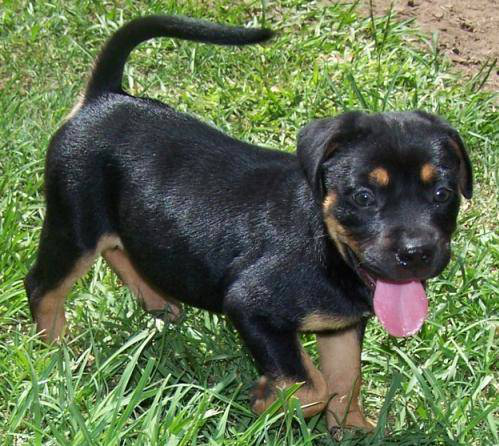

In [3]:
imagedog = Image.open('data/train/dog/dog.2112.jpg')
print(imagedog.height, 'x', imagedog.width)
imagedog

In [4]:
imagecat = Image.open('data/train/cat/cat.2112.jpg')

In [5]:
print(imagecat.height, 'x', imagecat.width)

375 x 499


In [6]:
def data_loader(data_type, batch_size):
    data_path = 'data/'+ data_type + '/'  # data_type = train/test

    dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        transform =  transforms.Compose([transforms.Resize((128,128)), 
                                         transforms.ToTensor(),
                                         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    )
    loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=1,
        pin_memory=True,
        shuffle=True
    )
    return loader

In [38]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1)     
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(246016, 128) # 64(no. of channels from conv2)*12*12 = 9216
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):        
        #x.shape = 32, 3, 400, 400 (N=batch size, C=channels, H=height, W=width)
        x = self.conv1(x) 
        #x.shape = 32, 32, 126, 126
        x = F.relu(x)        
        x = self.conv2(x) 
        # x.shape = 32, 64, 124, 124
        x = F.max_pool2d(x, 2) # stride=2 will reduce the dimensions to half
        # x.shape = 32, 64, 62, 62
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        # x.shape = 32, 246016 (64*62*62)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [39]:
m1 = Net()

In [40]:
torch.save(m1, 'test.pt')

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Dropout2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't b

In [36]:
m2 = torch.load("test.pt")

In [37]:
m2

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=246016, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

In [8]:
train_losses = []
def train(log_interval, model, device, train_loader, optimizer, epoch):
    model.train() # instructing pytorch that we want to train
    loss = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
#         running_loss += loss.item()
#         train_losses.append(running_loss/len(train_loader))
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    train_losses.append(loss.item())
    print(train_losses)
    

In [9]:
test_losses = []
def test(model, device, test_loader):
    model.eval() # instructing pytorch that we want to evaluate (and not train)
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [10]:
device = torch.device("cuda")

batch_size = 32
train_loader = data_loader('train', batch_size )
test_loader = data_loader('test', batch_size )
log_interval=600 # batches
lr = .001
epochs = 25
gamma = 0.7

model = Net()
model = nn.DataParallel(model) # We want to run on multiple GPUs
model.to(device)
optimizer = optim.Adadelta(model.parameters(), lr=lr)

scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

n = 1

print(model)

DataParallel(
  (module): Net(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout2d(p=0.25, inplace=False)
    (dropout2): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=246016, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
  )
)


In [31]:
params = list(model.parameters())
print(model.named_children)

<bound method Module.named_children of DataParallel(
  (module): Net(
    (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout2d(p=0.25, inplace=False)
    (dropout2): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=246016, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=2, bias=True)
  )
)>


In [ ]:
start_time = time.time()
print('starting at: ',time.strftime('%Y-%m-%d %H:%M:%S'))

for epoch in range(1, epochs + 1):
    print('Epoch: ', n)
    n+
    train(log_interval, model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

torch.save(model.state_dict(), "catdog_cnn.pt")

end_time = time.time()
print('ending  at: ',time.strftime('%Y-%m-%d %H:%M:%S'))
print('total time taken: ', round(end_time-start_time,2), ' seconds')

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(50), train_losses, 'r', label='train')
plt.plot(range(50), test_losses, 'g', label='test')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()

In [ ]:
device = torch.device("cuda")
imagedog = Image.open('data/train/dog/dog.2112.jpg')
print(imagedog.height, 'x', imagedog.width)
# predict_image(imagedog)

checkpoint=torch.load('catdog_cnn.pt')
test_transforms = transforms.Compose([transforms.Resize((128,128)),
                                  transforms.ToTensor(),
                                 ])
image_tensor = test_transforms(imagedog).float()
image_tensor = image_tensor.unsqueeze_(0)
input = Variable(image_tensor)
input = input.to(device)

In [ ]:
device = torch.device("cuda")
imagedog = Image.open('data/train/dog/dog.2112.jpg')

test_transforms = transforms.Compose([transforms.Resize((128,128)),
                                  transforms.ToTensor(),
                                 ])
image_tensor = test_transforms(imagedog).float().unsqueeze(0)

checkpoint=torch.load('catdog_cnn.pt')
model_inference = nn.DataParallel(Net()).to(device)
model_inference.load_state_dict(checkpoint)
model_inference(image_tensor)

In [ ]:
model_inference.eval()